# Use models with faster time between tokens

#### Load Helper Functions and Import Libraries

In [2]:
import datetime
import json
import time
import os
import datetime
import json
import time
from openai import AzureOpenAI
from dotenv import load_dotenv
import json
import copy
import textwrap

# Load environment variables
load_dotenv()

def aoai_call(system_message,prompt,model):
    client = AzureOpenAI(
        api_version=os.getenv("API_VERSION"),
        azure_endpoint=os.getenv("AZURE_ENDPOINT"),
        api_key=os.getenv("API_KEY")
    )

    start_time = time.time()

    completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": prompt},
        ],
    )

    end_time = time.time()
    e2e_time = end_time - start_time

    result=json.loads(completion.model_dump_json(indent=2))
    prompt_tokens=result["usage"]["prompt_tokens"]
    completion_tokens=result["usage"]["completion_tokens"]
    completion_text=result["choices"][0]["message"]["content"]

    return result,prompt_tokens,completion_tokens,completion_text,e2e_time


## Use case: Summarising a report

The use case is largely irrelevant to demonstrating the difference in speed between LLM models, however it is important that the smaller parameter model has the ability to actually achieve the use case.

In [5]:
documents_to_check="""

1. Pigeons’ Backflips Linked to Genetics Scientists have unraveled the genetic basis behind a fascinating avian behavior: some pigeons perform backward somersaults mid-flight. Dr. Avani Patel, a researcher at the Avian Genetics Institute, identified specific genes associated with this acrobatic feat in parlor roller pigeons. These findings shed light on the evolution of pigeon behavior and could have implications for understanding complex traits in other animals1.

2. Desert Ants’ Brain Adaptations to Magnetic Fields Researchers from the Desert Ecology Lab have revealed how magnetic fields shape the brains of desert ants. By studying the neural patterns in these tiny navigators, they discovered that the ants’ brains undergo structural changes in response to Earth’s magnetic field. This adaptation enhances their ability to find their way back to the nest, even in the harsh desert environment. The study provides fresh insights into the remarkable adaptations of these resilient insects1.

"""

### A: Naive summarisation, using the model's default verbosity

In [6]:
model=os.getenv("MODELGPT432k")

In [7]:
system_message="""
You help spell check documents. Rewrite the entire document word for word, correcting any spelling or grammatical errors.
"""
prompt=f"""
Documents to check and rewrite:
{documents_to_check}
"""

result,prompt_tokens,completion_tokens,completion_text,e2e_time=aoai_call(system_message,prompt,model)
print(f"Prompt Tokens: {prompt_tokens}")
print(f"Completion Tokens: {completion_tokens}")
print(f"Time taken: {e2e_time:.2f} seconds")
print(completion_text)


Prompt Tokens: 229
Completion Tokens: 189
Total cost: $0.0364
Time taken: 17.29 seconds


### B: Summarisation with a focus on conciseness

In [8]:
model=os.getenv("MODEL35")

In [9]:
system_message="""
You help spell check documents. Rewrite the entire document word for word, correcting any spelling or grammatical errors.
"""
prompt=f"""
Documents to check and rewrite:
{documents_to_check}
"""

result,prompt_tokens,completion_tokens,completion_text,e2e_time=aoai_call(system_message,prompt,model)
print(f"Prompt Tokens: {prompt_tokens}")
print(f"Completion Tokens: {completion_tokens}")
print(f"Time taken: {e2e_time:.2f} seconds")
print(completion_text)


Prompt Tokens: 229
Completion Tokens: 189
Total cost: $0.0364
Time taken: 4.68 seconds
1. Pigeons' Backflips Linked to Genetics: Scientists have unraveled the genetic basis behind a fascinating avian behavior: some pigeons perform backward somersaults mid-flight. Dr. Avani Patel, a researcher at the Avian Genetics Institute, identified specific genes associated with this acrobatic feat in parlor roller pigeons. These findings shed light on the evolution of pigeon behavior and could have implications for understanding complex traits in other animals.

2. Desert Ants' Brain Adaptations to Magnetic Fields: Researchers from the Desert Ecology Lab have revealed how magnetic fields shape the brains of desert ants. By studying the neural patterns in these tiny navigators, they discovered that the ants' brains undergo structural changes in response to the Earth's magnetic field. This adaptation enhances their ability to find their way back to the nest, even in the harsh desert environment. The

## Analysing benchmarks for Time-Between-Tokens

These benchmarks were developed using the AOAI benchmarking tool.

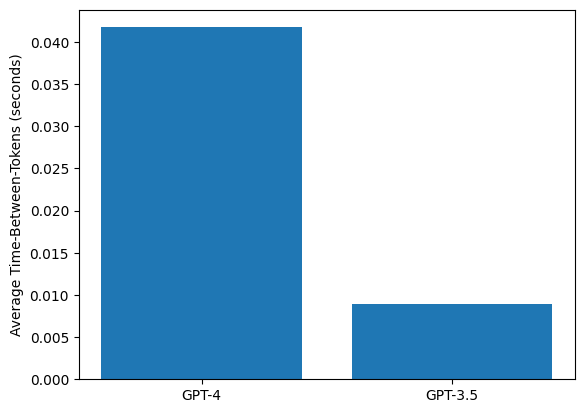

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files
df_gpt4 = pd.read_csv('stats_gpt4_rate_5_shape_custom_contexttokens_200_maxtokens_200_contextgenerationclass_story_generator_clients_60_duration_30_20231219_195219.csv')
df_gpt35 = pd.read_csv('stats_gpt35turbo0613_rate_5_shape_custom_contexttokens_200_maxtokens_200_contextgenerationclass_story_generator_clients_60_duration_300_20240114_232110.csv')

# Drop rows with NA in the 'tbt_avg' column
df_gpt4 = df_gpt4.dropna(subset=['tbt_avg'])
df_gpt35 = df_gpt35.dropna(subset=['tbt_avg'])

# Calculate the average of 'tbt_avg' for each DataFrame
gpt4_avg = df_gpt4['tbt_avg'].mean()
gpt3_avg = df_gpt3['tbt_avg'].mean()

# Plot the averages
plt.bar(['GPT-4', 'GPT-3.5'], [gpt4_avg, gpt3_avg])
plt.ylabel('Average Time-Between-Tokens (seconds)')
plt.show()